# 9. CHICAGO AIRBNB: MODEL TRAINING
---

## 1. The Data & Train-Test Split

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 999)
pd.set_option('precision', 3)

chicago = pd.read_csv('data/chicago_airbnb3')

num_cols = ['host_rr', 'host_ar', 'latitude', 'longitude', 'accommodates',
            'baths', 'bedrooms', 'beds', 'min_nights', 'max_nights', 'n_reviews', 
            'rs_rating', 'rs_accuracy', 'rs_cleanliness', 'rs_check_in', 
            'rs_communication', 'rs_location', 'rs_value', 'reviews_per_month']

cat_cols = ['host_rt', 'neighborhood', 'property_type', 'room_type']

train, test = train_test_split(chicago, test_size=0.2, random_state=42)

X_train = train.drop('price', axis=1)
y_train = train['price']

X_test = test.drop('price', axis=1)
y_test = test['price']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5240, 25), (5240,), (1310, 25), (1310,))

## 2. Preprocessing Pipeline

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeAdder(BaseEstimator, TransformerMixin):    
    def __init__(self):
        self    
        
    def fit(self, df, y = None):               
        return self

    def transform(self, df):        
        df_ = df.copy()
        df_['beds_per_bdrm'] = df_['beds']/df_['bedrooms']
        df_['baths_per_bed'] = df_['baths']/df_['beds']
        df_.replace(np.inf, 0, inplace=True)
        df_.replace(np.nan, 0, inplace=True)
        return df_
    
adder = AttributeAdder()
X_train_num = adder.fit_transform(train[num_cols])
print(X_train_num.shape)

(5240, 21)


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipe = Pipeline(steps = [
    ('add_features', AttributeAdder()),
    ('std_scaling', StandardScaler())
])
full_pipe = ColumnTransformer(
    transformers=[
        ('num_prep', num_pipe, num_cols),
        ('cat_prep', OneHotEncoder(), cat_cols)
    ])

X_train = full_pipe.fit_transform(X_train)
X_train

<5240x115 sparse matrix of type '<class 'numpy.float64'>'
	with 131000 stored elements in Compressed Sparse Row format>

So we have a sparse matrix (probably due to OneHotEncoding). We also have 115 features which is the same number that we got in the previous part when we used get_dummies. 

## 3. HTML Representation of Pipeline

In [4]:
from sklearn import set_config
set_config(display='diagram')

full_pipe

ColumnTransformer(transformers=[('num_prep',
                                 Pipeline(steps=[('add_features',
                                                  AttributeAdder()),
                                                 ('std_scaling',
                                                  StandardScaler())]),
                                 ['host_rr', 'host_ar', 'latitude', 'longitude',
                                  'accommodates', 'baths', 'bedrooms', 'beds',
                                  'min_nights', 'max_nights', 'n_reviews',
                                  'rs_rating', 'rs_accuracy', 'rs_cleanliness',
                                  'rs_check_in', 'rs_communication',
                                  'rs_location', 'rs_value',
                                  'reviews_per_month']),
                                ('cat_prep', OneHotEncoder(),
                                 ['host_rt', 'neighborhood', 'property_type',
                                  'room_type'])])

## 4. Training a Linear Regression Model

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

ols = LinearRegression()
ols_mse = cross_val_score(ols, X_train, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ols_rmse = np.sqrt(np.absolute(ols_mse))
print('RMSE:', ols_rmse)
print('Avg_RMSE:', ols_rmse.mean())
print('Std_RMSE:', ols_rmse.std())

RMSE: [425.93108859 183.52740766 134.72761984 138.45581251 413.15291056
 447.2906282  568.16886068 140.92118982 444.47672801 130.01073927]
Avg_RMSE: 302.6662985151705
Std_RMSE: 162.55875437222156


In [6]:
print('Price_Mean', y_train.mean())
print('Price_Std', y_train.std())

Price_Mean 156.58548282442754
Price_Std 360.2657343128557


As expected the model performed horrendously as we can see that the actual mean price is almost half of the error. 

## 5. Tracking Model Performance

In [7]:
model_index = ['rmse_1','rmse_2', 'rmse_3', 'rmse_4', 'rmse_5', 'rmse_6', 'rmse_7',
             'rmse_8', 'rmse_9', 'rmse_10', 'avg_rmse', 'std_rmse']
model_df = pd.DataFrame(index=model_index)
model_df['OLS_LR_all'] = [425.93108859, 183.52740766, 134.72761984, 138.45581251, 413.15291056,
               447.2906282,  568.16886068, 140.92118982, 444.47672801, 130.01073927, 
               302.6662985151705, 162.55875437222156]
model_df

,OLS_LR_all
rmse_1,425.931
rmse_2,183.527
rmse_3,134.728
rmse_4,138.456
rmse_5,413.153
rmse_6,447.291
rmse_7,568.169
rmse_8,140.921
rmse_9,444.477
rmse_10,130.011


## 6. Training an ElasticNetCV Model

In [8]:
from sklearn.linear_model import ElasticNetCV

ratio = [.1, .5, .7, .8, .9, .95, .99, 1]
alpha = np.logspace(-1, .5, 8)
elast_cv = ElasticNetCV(l1_ratio=ratio, alphas=alpha, 
                        cv=10, n_jobs=-1, max_iter=10000)
elast_cv.fit(X_train, y_train)
print('ElasticNet_n_iter:', elast_cv.n_iter_)
print('ElasticNet_l1_ratio:', elast_cv.l1_ratio_)
print('ElasticNet_alpha:', elast_cv.alpha_)

ElasticNet_n_iter: 47
ElasticNet_l1_ratio: 0.7
ElasticNet_alpha: 0.1


In [9]:
np.logspace(-1, .5, 8)

array([0.1       , 0.16378937, 0.26826958, 0.43939706, 0.71968567,
       1.17876863, 1.93069773, 3.16227766])

In [10]:
elast_cv.coef_

array([-1.71326058e+01, -2.16210072e-01,  1.96262475e+01,  2.15549730e+01,
        3.15793436e+01,  4.81762340e+01,  6.37835054e+00,  4.39066486e+01,
        5.01914805e+00,  9.27186782e-01, -4.58491269e+00,  3.87285865e+00,
        4.53349910e+00,  9.50461158e+00, -3.20578882e+00, -1.41250668e+00,
        8.38220044e+00, -1.05682700e+01, -1.13967469e+01, -3.25833597e+01,
       -9.25599142e+00, -1.61033032e+01,  6.30409660e+00,  5.96354769e+00,
       -2.12855464e+01,  2.27874830e+01, -8.61618481e+00,  0.00000000e+00,
       -4.19989937e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -7.95465513e-02, -3.89152726e+00,  0.00000000e+00,  0.00000000e+00,
       -1.26193164e+01,  0.00000000e+00, -0.00000000e+00, -3.18694458e+00,
       -1.85927691e-01,  0.00000000e+00,  0.00000000e+00, -2.76051982e+00,
        0.00000000e+00, -2.12010979e-01, -1.81361673e+01, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

## 7. ElasticNet Feature Importances
Let's get the names of the columns from previous chapter when we used `get_dummies`

In [11]:
chic_115cols = pd.read_csv('data/chicago_airbnb4')
X_train_cols = chic_115cols.columns
X_train_cols

Index(['host_rr', 'host_ar', 'superhost', 'latitude', 'longitude',
       'accommodates', 'baths', 'bedrooms', 'beds', 'min_nights',
       ...
       'property_type_hotel', 'property_type_house', 'property_type_loft',
       'property_type_other', 'property_type_suite', 'property_type_townhouse',
       'room_type_Entire place', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object', length=115)

In [12]:
features_df = pd.DataFrame()
features_df['feature'] = X_train_cols
features_df['coef'] = elast_cv.coef_
features_df['abs_coef'] = features_df['coef'].abs()
features_df = features_df.sort_values('abs_coef', 
                                      ascending=False)
print(features_df.shape)
non_zero_features = features_df[features_df['coef']!=0]
non_zero_features.head(20)

(115, 3)


,feature,coef,abs_coef
105,property_type_hotel,68.160,68.160
62,neighborhood_Lake View,48.534,48.534
5,accommodates,48.176,48.176
7,bedrooms,43.907,43.907
66,neighborhood_Loop,42.430,42.430
72,neighborhood_Near North Side,37.766,37.766
19,instant_bookable,-32.583,32.583
4,longitude,31.579,31.579
104,property_type_condomium,-28.986,28.986
100,neighborhood_West Town,27.672,27.672


## 8. Visualizing Feature Importances

Let's plot the coefficients from `ElasticNetCV` to better see which ones to choose for turning our algorithms

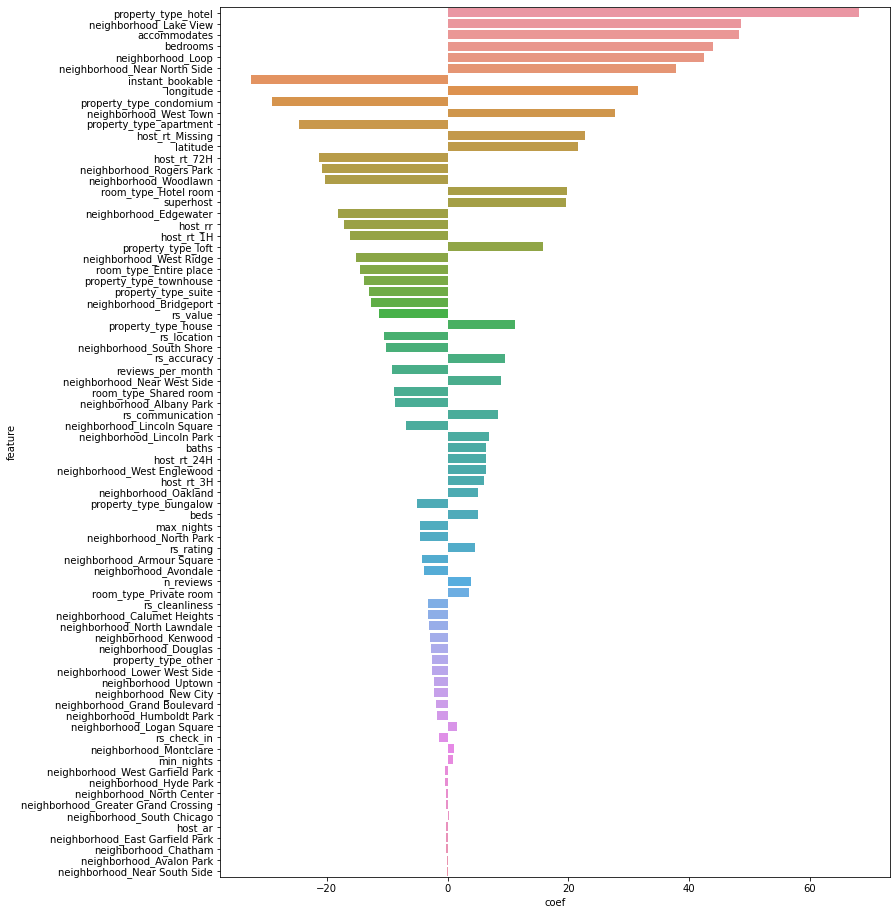

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,16))
ax = sns.barplot(x="coef", y="feature", data=non_zero_features)

## 9. Retraining OLS-Linear Model Using Best 36 Features

In [14]:
cols_36 = list(non_zero_features['feature'].head(36))
X_train_dense = X_train.toarray()
X_train_dense = pd.DataFrame(X_train_dense, columns=X_train_cols)
X_train_36 = X_train_dense[cols_36].copy()
print(X_train_36.shape)
X_train_36.head()

(5240, 36)


,property_type_hotel,neighborhood_Lake View,accommodates,bedrooms,neighborhood_Loop,neighborhood_Near North Side,instant_bookable,longitude,property_type_condomium,neighborhood_West Town,property_type_apartment,host_rt_Missing,latitude,host_rt_72H,neighborhood_Rogers Park,neighborhood_Woodlawn,room_type_Hotel room,superhost,neighborhood_Edgewater,host_rr,host_rt_1H,property_type_loft,neighborhood_West Ridge,room_type_Entire place,property_type_townhouse,property_type_suite,neighborhood_Bridgeport,rs_value,property_type_house,rs_location,neighborhood_South Shore,rs_accuracy,reviews_per_month,neighborhood_Near West Side,room_type_Shared room,neighborhood_Albany Park
0,0.0,1.0,-0.320,1.049,0.0,0.0,-0.374,1.354,0.0,0.0,1.0,0.0,-0.075,0.0,0.0,0.0,0.0,0.967,0.0,0.325,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.875,0.0,-0.771,0.0,-0.822,-1.167,0.0,0.0,0.0
1,0.0,0.0,-0.320,0.489,0.0,0.0,0.451,0.650,0.0,0.0,0.0,0.0,-0.623,0.0,0.0,0.0,0.0,0.343,0.0,0.325,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.158,1.0,0.526,0.0,0.461,-0.943,0.0,0.0,0.0
2,0.0,0.0,-0.320,-0.629,0.0,0.0,-0.374,-0.758,0.0,0.0,1.0,1.0,-2.329,0.0,0.0,0.0,0.0,0.868,0.0,0.325,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.129,0.0,0.526,0.0,0.461,0.845,0.0,0.0,0.0
3,0.0,0.0,-0.643,-0.070,0.0,0.0,1.275,-0.758,0.0,0.0,0.0,0.0,-0.087,0.0,1.0,0.0,0.0,1.794,0.0,0.325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.573,1.0,0.526,0.0,0.461,-0.831,0.0,0.0,0.0
4,0.0,0.0,-0.320,-0.629,0.0,0.0,-0.374,-0.406,0.0,0.0,1.0,0.0,1.275,0.0,0.0,0.0,0.0,-3.565,0.0,0.325,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.493,0.0,0.526,0.0,0.461,0.845,0.0,0.0,0.0


In [15]:
from sklearn.model_selection import KFold

ols = LinearRegression()
kf = KFold(n_splits=10, random_state=42, shuffle=True)
ols_mse = cross_val_score(ols, X_train_36, y_train, cv=kf, n_jobs=-1, 
                          scoring="neg_mean_squared_error") 
ols_rmse = np.sqrt(np.absolute(ols_mse))
print('RMSE:', ols_rmse)
print('Avg_RMSE:', ols_rmse.mean())
print('Std_RMSE:', ols_rmse.std())

RMSE: [552.85926868 210.80167345 123.6281426  128.24445457 590.70288076
 463.42082567 143.51566033 123.25094313 129.99480711 412.47683308]
Avg_RMSE: 287.88954893941775
Std_RMSE: 184.2632445272487


## 10. Retraining ElasticNet Using Best 36

In [16]:
from sklearn.linear_model import ElasticNet

elas_net = ElasticNet(alpha=0.1, l1_ratio=0.7)
elas_mse = cross_val_score(elas_net, X_train_36, y_train, cv=kf, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
elas_rmse = np.sqrt(np.absolute(elas_mse))
print('RMSE:', elas_rmse)
print('Avg_RMSE:', elas_rmse.mean())
print('Std_RMSE:', elas_rmse.std())

RMSE: [552.81914494 210.35895428 118.10562924 123.10313937 590.50079696
 461.62975661 138.46093959 119.28411103 123.14145802 412.35020263]
Avg_RMSE: 284.9754132666877
Std_RMSE: 186.34463238734193


The ordinary least squares linear and the regularized elastic net models don't seem to yield good results. This is somewhat not surprising because  we did not find strong linear relationship between features and target. We will keep looking for better models.

Let's now update or model performance tracker

In [17]:
model_df['OLS_LR_36'] = [552.85926868, 210.80167345, 123.6281426,  128.24445457, 590.70288076,
                      463.42082567, 143.51566033, 123.25094313, 129.99480711, 412.47683308,
                      287.88954893941775, 184.2632445272487]
model_df['ElasNet_36'] = [552.81914494, 210.35895428, 118.10562924, 123.10313937, 590.50079696,
                          461.62975661, 138.46093959, 119.28411103, 123.14145802, 412.35020263,
                          284.9754132666877, 186.34463238734193]
model_df

,OLS_LR_all,OLS_LR_36,ElasNet_36
rmse_1,425.931,552.859,552.819
rmse_2,183.527,210.802,210.359
rmse_3,134.728,123.628,118.106
rmse_4,138.456,128.244,123.103
rmse_5,413.153,590.703,590.501
rmse_6,447.291,463.421,461.630
rmse_7,568.169,143.516,138.461
rmse_8,140.921,123.251,119.284
rmse_9,444.477,129.995,123.141
rmse_10,130.011,412.477,412.350


## 11. Training K-Nearest Neighbor Regression

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

kpar = {'n_neighbors': np.arange(1, 21, 2),
       'weights': ['uniform', 'distance'],
       'algorithm': ['ball_tree', 'kd_tree', 'brute'],
       'p': [1,2]
      }
knn = KNeighborsRegressor()
kgrid = GridSearchCV(knn, kpar, n_jobs=-1)
kgrid.fit(X_train_dense, y_train)

print('Best Parameters:', kgrid.best_params_)
print('Best Score:', kgrid.best_score_)

Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Best Score: 0.11631657498150494


In [19]:
knn = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=19, 
                        p=1, weights='uniform')
knn_mse = cross_val_score(knn, X_train_dense, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
knn_rmse = np.sqrt(np.absolute(knn_mse))
print('RMSE:', knn_rmse)
print('Avg_RMSE:', knn_rmse.mean())
print('Std_RMSE:', knn_rmse.std())

RMSE: [417.2192649  185.51412781 123.41564852 135.15090507 419.74317281
 450.73621762 566.42378049 134.05568276 442.4125294  113.69091099]
Avg_RMSE: 298.8362240368504
Std_RMSE: 166.060974249007


It looks like we are going to have a hard time finding a decent model for all of these useless features. Let's train random forest before deciding on anything different

## 12. Training Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor

ranpar = {'max_depth': [2, 4, 6, 8],
          'min_samples_leaf': [1, 2, 3, 4],
          'min_samples_split':[2, 3, 4, 5]
         }
ran = RandomForestRegressor()
rangrid = GridSearchCV(ran, ranpar, n_jobs=-1)
rangrid.fit(X_train_dense, y_train)

print('Best Parameters:', rangrid.best_params_)
print('Best Score:', rangrid.best_score_)

Best Parameters: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Score: 0.09940749034071887


In [21]:
ranfo = RandomForestRegressor(max_depth=4, min_samples_leaf=4,
                            min_samples_split=5, random_state=42)
ranfo_mse = cross_val_score(ranfo, X_train_dense, y_train, cv=10, n_jobs=-1, 
                             scoring="neg_mean_squared_error") 
ranfo_rmse = np.sqrt(np.absolute(ranfo_mse))
print('RMSE:', ranfo_rmse)
print('Avg_RMSE:', ranfo_rmse.mean())
print('Std_RMSE:', ranfo_rmse.std())

RMSE: [422.30621467 184.97934005 134.96087479 136.02076044 421.21129004
 449.10284586 572.34843496 150.10579094 447.13622224 114.37442543]
Avg_RMSE: 303.2546199416678
Std_RMSE: 164.88827791922378


In [22]:
model_df['KNN_all'] = [417.2192649, 185.51412781, 123.41564852, 135.15090507,
                       419.74317281, 450.73621762, 566.42378049, 134.05568276,
                       442.4125294, 113.69091099, 298.8362240368504, 166.060974249007]
model_df['RandFor_all'] = [422.30621467, 184.97934005, 134.96087479, 136.02076044,
                           421.21129004, 449.10284586, 572.34843496, 150.10579094,
                           447.13622224, 114.37442543, 303.2546199416678, 164.88827791922378]
model_df

,OLS_LR_all,OLS_LR_36,ElasNet_36,KNN_all,RandFor_all
rmse_1,425.931,552.859,552.819,417.219,422.306
rmse_2,183.527,210.802,210.359,185.514,184.979
rmse_3,134.728,123.628,118.106,123.416,134.961
rmse_4,138.456,128.244,123.103,135.151,136.021
rmse_5,413.153,590.703,590.501,419.743,421.211
rmse_6,447.291,463.421,461.630,450.736,449.103
rmse_7,568.169,143.516,138.461,566.424,572.348
rmse_8,140.921,123.251,119.284,134.056,150.106
rmse_9,444.477,129.995,123.141,442.413,447.136
rmse_10,130.011,412.477,412.350,113.691,114.374


It looks like we have too many features that can't agree on a good model. In the next chapter we will apply some dimensionality reduction and see if we make progress. 

In [23]:
X_train_dense.to_csv('data/chicago_airbnb5_Xtd', index=False)
model_df.to_csv('data/chicago_airbnb5_models', index=False)